# **Quantum control protocol for a three-level lambda system.**




---

## 1. Control Hamiltonian and Discretization

### 1.1 General Formulation

In quantum control, the system Hamiltonian is decomposed as::

$$
\hat{H}(t) = \hat{H}_d + \sum_{k=1}^{M} u_k(t) \hat{H}_k
$$

where:

- $\hat{H}_d$: **Drift Hamiltonian**, the uncontrollable part of the system
- $\hat{H}_k$: **Control Hamiltonians**, operators that couple to external fields
- $u_k(t)$: **Control Functions** (pulsos), time-dependent parameters that can be adjusted
- $M$: Number of available control channels

#### Example: Qubit in a Magnetic Field

$$
\hat{H}(t) = \frac{\omega_0}{2}\sigma_z + \Omega_x(t)\frac{\sigma_x}{2} + \Omega_y(t)\frac{\sigma_y}{2}
$$

- $\hat{H}_d = \frac{\omega_0}{2}\sigma_z$ (energy splitting)
- $\hat{H}_1 = \frac{\sigma_x}{2}$, $\hat{H}_2 = \frac{\sigma_y}{2}$ (orthogonal controls)
- $u_1(t) = \Omega_x(t)$, $u_2(t) = \Omega_y(t)$ (Rabi amplitudes)

### 1.2 Time Discretization

In practice, we work with **piecewise-constant discrete controls:**

- Divide the time interval $[0, T]$ into $N$ steps: $t_j = j\Delta t$, where $\Delta t = T/N$
- Approximate each $u_k(t)$ as constant within each interval:: $u_k(t) \approx u_k[j]$ for $t \in [t_j, t_{j+1})$

The Hamiltonian at step $j$ becomes:

$$
\hat{H}_j = \hat{H}_d + \sum_{k=1}^{M} u_k[j] \hat{H}_k
$$

### 1.3 Discrete Propagator:

The evolution during one time step is::

$$
\hat{U}_j = e^{-i \hat{H}_j \Delta t} = \exp\left(-i\Delta t\left(\hat{H}_d + \sum_k u_k[j]\hat{H}_k\right)\right)
$$

The **total propagator** from de $t=0$ to $t=T$ is the ordered composition:

$$
\hat{U}_{\text{total}} = \hat{U}_{N-1} \cdots \hat{U}_1 \hat{U}_0 = \prod_{j=0}^{N-1} \hat{U}_j
$$

(Note: the product is ordered with increasing indices to the right; time flows to the left.)


### 1.4 Numerical Considerations

- **Choice of $\Delta t$:** It must be sufficiently small for the piecewise-constant approximation to remain valid. A practical rule: $\Delta t \ll 1/||\hat{H}||$
- **Matrix exponential computation**: Use specialized algorithms (diagonalization, Padé approximation, Krylov methods) depending on system dimension
- **Unitarity check:** $\hat{U}^\dagger \hat{U} = \mathbb{I}$ (numerical errors may accumulate)

---

## 2. Implementation of the Open Quantum Dynamics Model for a Lambda System

In this section, we construct the operators and equations required to simulate the coherent and dissipative dynamics of a three-level system in the Λ configuration.

### 2.1 System Operators

The transition and projection operators are defined as:
$$
\sigma_{ij} = |i\rangle \langle j|
$$
These operators allow us to describe:
- Coherent transitions induced by external fields
- Diagonal projectors used in pure dephasing terms
- Lowering operators associated with spontaneous decay

---

### 2.2 Time-Dependent Hamiltonian (RWA)

Under the rotating frame and the rotating-wave approximation (RWA), the system is described in a basis rotating at the frequency of the applied laser. This transformation removes the explicit dependence on the optical laser frequency from the Hamiltonian. Physically, this means that we focus only on the relevant near-resonant dynamics, discarding rapidly oscillating terms that average to zero over timescales relevant to the system's evolution.

As a result, the effective Hamiltonian is expressed in terms of detunings and Rabi frequencies, simplifying the description without losing accuracy when the laser frequency is close to the atomic transition and the Rabi frequency is much smaller than the optical frequency.

In this framework, the coherent Hamiltonian takes the form

$$
H(t) = H_0 + \frac{\Omega_p(t)}{2}(\sigma_{31} + \sigma_{13})
+ \frac{\Omega_s(t)}{2}(\sigma_{32} + \sigma_{23})
$$

where:

- $H_0 = \delta \sigma_{22} + \Delta_2 \sigma_{33}$ represents the detunings.
- $\Omega_p(t)$ and $\Omega_s(t)$ are the Rabi frequencies of the pump and Stokes fields.

---

### 2.3 Open-System Dynamics: Lindblad Master Equation

In a realistic scenario, the atom is not perfectly isolated but interacts with its environment (electromagnetic vacuum, thermal fluctuations, phase noise, etc.). To model these irreversible effects, the Lindblad master equation is used to describe the evolution of the density matrix in an open quantum system.

The full dynamics are governed by:
$$
\dot{\rho} = -i[H(t),\rho] + \sum_k \mathcal{D}[L_k]\rho,
$$

where the dissipative superoperator is defined as:
$$
\mathcal{D}[L]\rho = L\rho L^\dagger - \frac{1}{2}\{L^\dagger L,\rho\}.
$$
The first contribution corresponds to the coherent unitary evolution generated by the Hamiltonian, while the second term describes irreversible processes induced by the environment.

To model environmental interactions, collapse operators are introduced:

- **Spontaneous decay:**
Radiative processes from the excited state $|3\rangle$ to the ground states are considered:
  $$
  L_{31} = \sqrt{\gamma_{31}} |1\rangle\langle 3|,\quad
  L_{32} = \sqrt{\gamma_{32}} |2\rangle\langle 3|
  $$
These operators model spontaneous emission, leading to population loss from the excited level and incoherent transfer to the ground states.

- **Desfase puro:**  
Pure dephasing terms are also included

  $
  L_i = \sqrt{\gamma_{\phi i}} |i\rangle\langle i|
  $

These processes do not modify populations but suppress quantum coherences (off-diagonal elements of $\rho$), representing phase fluctuations induced by the environment.

---

### 2.4 Success Metric

The fidelity with respect to a pure target state is computed as:
$$
F = \langle \psi_{\text{target}} | \rho(T) | \psi_{\text{target}} \rangle
$$

allowing the efficiency of state transfer to be quantified in the presence of noise.


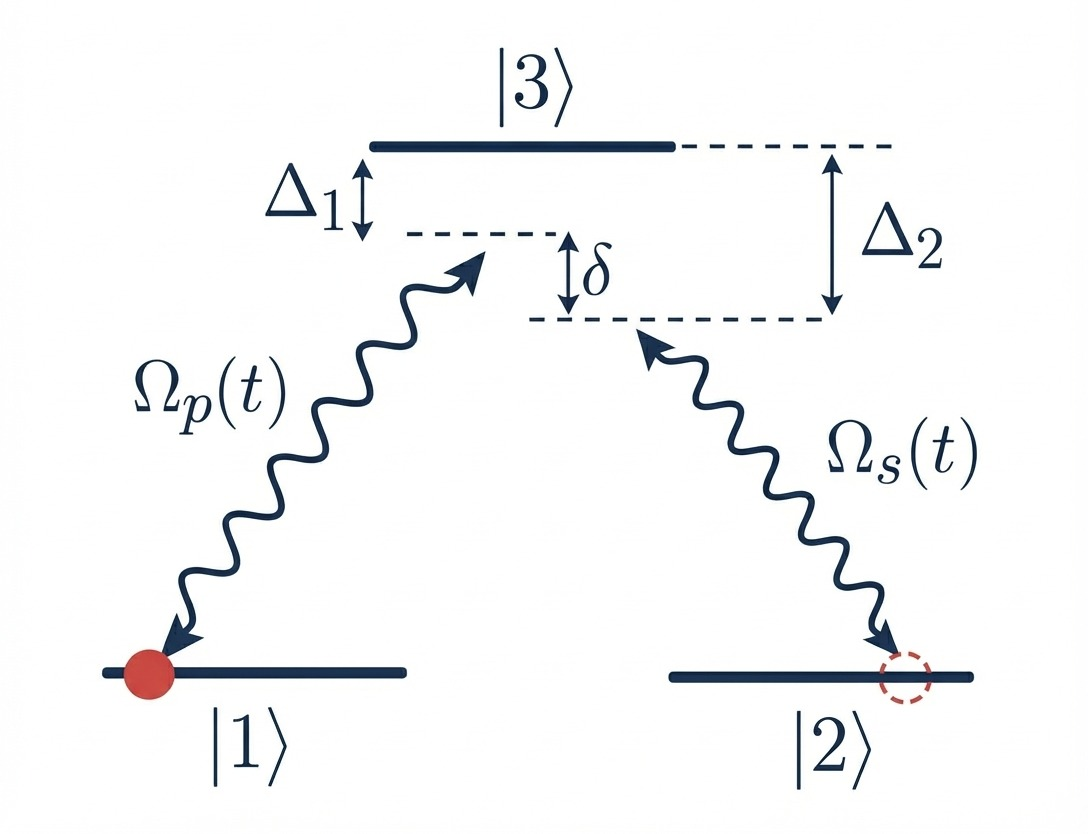

In [4]:
!pip install qutip numpy matplotlib


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [5]:
import numpy as np
import qutip as qt

def build_ops():
    e1, e2, e3 = qt.basis(3,0), qt.basis(3,1), qt.basis(3,2)
    def sigma(i,j):
        basis = [e1,e2,e3]
        return basis[i-1]*basis[j-1].dag()
    return {
        "e1": e1, "e2": e2, "e3": e3,
        "s11": sigma(1,1), "s22": sigma(2,2), "s33": sigma(3,3),
        "s13": sigma(1,3), "s31": sigma(3,1),
        "s23": sigma(2,3), "s32": sigma(3,2),
    }

def make_H_and_cops(ops, delta, Delta2, Omega_p_fn, Omega_s_fn, gammas):
    """
    Construct the Hamiltonian H and collapse operators (c_ops) for
    the complete simulation of the Lindblad master equation.

    H_s(t) is the coherent Hamiltonian (RWA).
    c_ops includes Spontaneous Decay (|3> -> |1>, |2>) y Desfase Puro (|i><i|).

    Se espera que gammas sea una tupla de cinco elementos:
    (gamma_3_to_1, gamma_3_to_2, gamma_deph_1, gamma_deph_2, gamma_deph_3)
    """

    # 1. Hamiltonian Components (H)
    s11, s22, s33 = ops["s11"], ops["s22"], ops["s33"]

    # Operadores de acoplamiento de campo (sin coeficientes 0.5)
    Hp = ops["s31"] + ops["s13"]
    Hs = ops["s32"] + ops["s23"]

    # Parte estática (detunings)
    H0 = delta*s22 + Delta2*s33

    # Coeficientes dependientes del tiempo (incluyen el factor 0.5 de Rabi)
    def Op_coeff(t, args): return 0.5 * Omega_p_fn(t, args)
    def Os_coeff(t, args): return 0.5 * Omega_s_fn(t, args)

    H = [H0, [Hp, Op_coeff], [Hs, Os_coeff]]

    # 2. Operadores de Colapso (c_ops) para la Dinámica Abierta

    # Desempaquetar las tasas de disipación (requiere 5 valores)
    try:
        gamma31, gamma32, gammap1, gammap2, gammap3 = gammas
    except ValueError:
        print("ERROR: La tupla 'gammas' debe contener 5 tasas (Decaimiento 3->1, 3->2, Desfase 1, Desfase 2, Desfase 3).")
        raise

    c_ops = []

    # A. Decaimiento Espontáneo (Pérdida de Población: |3> -> |j>)
    # Los operadores son de bajada: |1><3| (s13) y |2><3| (s23)

    # Decay |3> -> |1>
    if gamma31 > 0:
        c_ops.append(np.sqrt(gamma31) * ops["s13"])

    # Decay |3> -> |2>
    if gamma32 > 0:
        c_ops.append(np.sqrt(gamma32) * ops["s23"])

    # B. Desfase Puro (Pérdida de Coherencia: L_i = sqrt(gamma_pi) * |i><i|)
    # Los operadores son proyectores diagonales: s11, s22, s33

    # Dephasing en estado |1>
    if gammap1 > 0:
        c_ops.append(np.sqrt(gammap1) * s11)

    # Dephasing en estado |2>
    if gammap2 > 0:
        c_ops.append(np.sqrt(gammap2) * s22)

    # Dephasing en estado |3>
    if gammap3 > 0:
        c_ops.append(np.sqrt(gammap3) * s33)

    return H, c_ops

def simulate_mastereq(ops, H, c_ops, tlist, rho0):
    e_ops = [ops["s11"], ops["s22"], ops["s33"]]
    # QuTiP 5: usar options={"store_states": True} en lugar de qt.Options
    res = qt.mesolve(H, rho0, tlist, c_ops=c_ops, e_ops=e_ops, args={}, options={"store_states": True})

    pops = np.array(res.expect)          # P1,P2,P3
    rhoT = res.states[-1]                # ahora sí existe
    return pops, rhoT

def fidelity_target_pure(rho, ket_target):
    # QuTiP 5: el producto puede devolver un escalar o un Qobj
    result = ket_target.dag() * rho * ket_target
    # Verificar si es un Qobj o un escalar
    if hasattr(result, 'full'):
        return float(result.full()[0,0].real)
    else:
        # Es un escalar complejo
        return float(np.real(result))

## 3 Definition of Gaussian Pulses for STIRAP

---
In this section, the temporal pulses used to implement the STIRAP protocol in a Λ system are defined.

### 3.2 Functional Form of the Pulses

Gaussian pulses are used for the Rabi frequencies:
$$
\Omega_p(t) = \Omega_{13}\exp\left(-\frac{(t-t_p)^2}{2\sigma^2}\right)
$$

$$
\Omega_s(t) = \Omega_{23}\exp\left(-\frac{(t-t_s)^2}{2\sigma^2}\right)
$$

where:

- $\Omega_{13}$ and $\Omega_{23}$ are the peak amplitudes.
- $t_p$ and $t_s$ are the temporal centers..
- $\sigma$ controls the pulse width.

Gaussian pulses are smooth and favor the fulfillment of the adiabatic condition.

---

### 3.3 Temporal Ordering of the Pulses

The efficiency of STIRAP critically depends on the temporal ordering:
- **Counterintuitive (STIRAP verdadero):**  
  The Stokes pulse precedes the Pump pulse (\(t_s < t_p\)).  
  This allows the system to adiabatically follow the dark state:

  $$
  |D(t)\rangle = \cos\theta(t)|1\rangle - \sin\theta(t)|2\rangle
  $$

  thereby avoiding population of the excited state $|3\rangle$.

- **Intuitive:**  
  The Pump pulse precedes the Stokes pulse ($t_p < t_s$), leading to significant population of the intermediate state and reduced robustness.

---

### 3.4 Temporal Separation

The separation $T_{sep} = |t_p - t_s|$ controls the degree of adiabaticity of the process.

An initial temporal offset of approximately \(3\sigma\) is introduced to ensure that the pulses start at nearly zero amplitude, avoiding truncation effects.


In [6]:
def gaussian_pulses(Omega13, Omega23, tp, ts, sigma):
    # Ωp(t)=Ω13 exp(-(t-tp)^2/(2σ^2)), Ωs(t)=Ω23 exp(-(t-ts)^2/(2σ^2))
    def Omega_p(t, args):
        return Omega13*np.exp(-(t-tp)**2/(2*sigma**2))
    def Omega_s(t, args):
        return Omega23*np.exp(-(t-ts)**2/(2*sigma**2))
    return Omega_p, Omega_s

def stirap_times(Tsep, order="counter"):
    # centers tp, ts; counter: Stokes first (ts<tp). intuitive: Pump first.
    # Ajustamos para que los pulsos empiecen desde t=0 con margen de 3*sigma
    t_offset = 3 * 3.0  # 3*sigma para dar margen al inicio del pulso
    if order == "counter":
        ts, tp = t_offset, t_offset + Tsep
    elif order == "intuitive":
        tp, ts = t_offset, t_offset + Tsep
    else:
        raise ValueError("order must be 'counter' or 'intuitive'")
    return tp, ts

# 4 STIRAP Protocol
Stimulated Raman Adiabatic Passage (STIRAP) is a technique that enables population transfer between two states without populating the intermediate state.

The protocol proposes the following sequence:
1.   A Stokes pulse acts first.
2.   A Pump pulse acts second.

This sequence is called **counterintuitive** and creates a dark state that evolves adiabatically.

Compared to other control protocols, STIRAP presents the following advantages:
1.   It avoids losses due to decay by suppressing population of the intermediate state.
2.   It is robust against parameter variations (insensitive to small changes in the control pulses).
3.   It achieves high transfer fidelity.

In contrast, the intuitive sequence is as follows:
1.   A Pump pulse acts first.
2.   A Stokes pulse acts second.

As will be shown later, this sequence induces a transition to the intermediate state and subsequently leads to population of an undesired state.

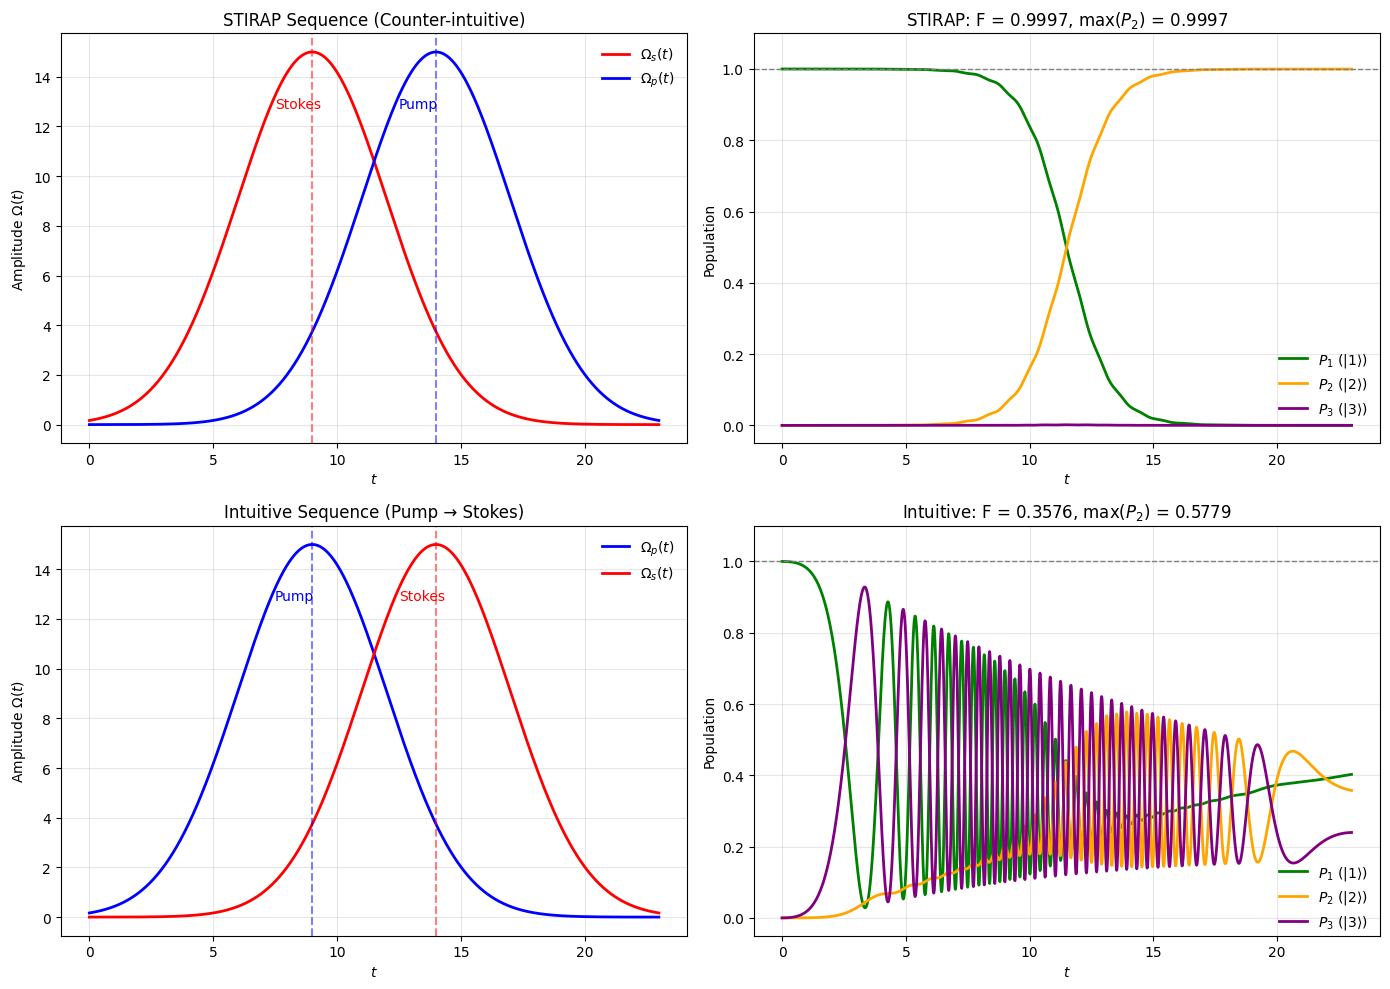


COMPARACIÓN: STIRAP vs Secuencia Intuitiva
Métrica                             STIRAP          Intuitiva      
----------------------------------------------------------------------
Fidelidad final                             0.9997         0.3576
Población máxima en |2⟩                     0.9997         0.5779


In [7]:
# ==================== VISUALIZACIÓN STIRAP (2x2) ====================

import matplotlib.pyplot as plt
import numpy as np

ops = build_ops()

# Parámetros de pulsos
Omega13, Omega23 = 15.0, 15.0
Tsep = 5.0
sigma_pulse = 3.0

# tiempo de simulación (debe cubrir todo el rango de los pulsos)
t_offset = 3 * sigma_pulse
t_total = t_offset + Tsep + 3*sigma_pulse
tlist = np.linspace(0, t_total, 2001)

# condiciones
rho0 = qt.ket2dm(ops["e1"])          # ρ(0)=|1><1|
ket_target = ops["e2"]               # objetivo: |2>
delta = 0.0
Delta2 = 0.0
# gammas = (Decaimiento 3->1, 3->2, Desfase 1, Desfase 2, Desfase 3)
Gamma_total_decay = 0.1
gammas = (Gamma_total_decay/2, Gamma_total_decay/2, 0.0, 0.0, 0.0)

# Función run_stirap
def run_stirap(order, Omega13=10.0, Omega23=10.0, Tsep=5.0, sigma=3.0):
    tp, ts = stirap_times(Tsep, order=order)
    Op, Os = gaussian_pulses(Omega13, Omega23, tp, ts, sigma)
    H, c_ops = make_H_and_cops(ops, delta, Delta2, Op, Os, gammas)
    pops, rhoT = simulate_mastereq(ops, H, c_ops, tlist, rho0)
    F = fidelity_target_pure(rhoT, ket_target)
    return Op, Os, pops, F

# Ejecutar ambas secuencias
OpC, OsC, popsC, FC = run_stirap("counter", Omega13, Omega23, Tsep, sigma_pulse)
OpI, OsI, popsI, FI = run_stirap("intuitive", Omega13, Omega23, Tsep, sigma_pulse)

# Extraer poblaciones
P1C, P2C, P3C = popsC
P1I, P2I, P3I = popsI

# Calcular máximos de P2
P2_max_counter = np.max(P2C)
P2_max_intuitive = np.max(P2I)

# Tiempos centrales de pulsos
tp_counter, ts_counter = stirap_times(Tsep, order="counter")
tp_intuitive, ts_intuitive = stirap_times(Tsep, order="intuitive")

# ==================== FIGURA 2x2 ====================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ========== Subplot 1: Pulsos STIRAP (Contra-intuitiva) ==========
ax1 = axes[0, 0]
Omega_s_array = np.array([OsC(t, None) for t in tlist])
Omega_p_array = np.array([OpC(t, None) for t in tlist])

ax1.plot(tlist, Omega_s_array, 'r-', linewidth=2, label=r'$\Omega_s(t)$')
ax1.plot(tlist, Omega_p_array, 'b-', linewidth=2, label=r'$\Omega_p(t)$')
ax1.axvline(x=ts_counter, color='r', linestyle='--', alpha=0.5)
ax1.axvline(x=tp_counter, color='b', linestyle='--', alpha=0.5)
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'Amplitude $\Omega(t)$')
ax1.set_title('STIRAP Sequence (Counter-intuitive)')
ax1.legend(frameon=False)
ax1.grid(True, alpha=0.3)
ax1.text(ts_counter-1.5, Omega23*0.85, 'Stokes', fontsize=10, color='red')
ax1.text(tp_counter-1.5, Omega13*0.85, 'Pump', fontsize=10, color='blue')

# ========== Subplot 2: Poblaciones STIRAP ==========
ax2 = axes[0, 1]
ax2.plot(tlist, P1C, 'g-', linewidth=2, label=r'$P_1$ (|1⟩)')
ax2.plot(tlist, P2C, 'orange', linewidth=2, label=r'$P_2$ (|2⟩)')
ax2.plot(tlist, P3C, 'purple', linewidth=2, label=r'$P_3$ (|3⟩)')
ax2.axhline(y=1.0, color='gray', linestyle='--', linewidth=1)
ax2.set_xlabel(r'$t$')
ax2.set_ylabel('Population')
ax2.set_title(f'STIRAP: F = {FC:.4f}, max($P_2$) = {P2_max_counter:.4f}')
ax2.legend(frameon=False,loc="lower right", bbox_to_anchor=(1.0, 0.03))
ax2.grid(True, alpha=0.3)
ax2.set_ylim([-0.05, 1.1])

# ========== Subplot 3: Pulsos Intuitivos ==========
ax3 = axes[1, 0]
Omega_s_int = np.array([OsI(t, None) for t in tlist])
Omega_p_int = np.array([OpI(t, None) for t in tlist])

ax3.plot(tlist, Omega_p_int, 'b-', linewidth=2, label=r'$\Omega_p(t)$')
ax3.plot(tlist, Omega_s_int, 'r-', linewidth=2, label=r'$\Omega_s(t)$')
ax3.axvline(x=tp_intuitive, color='b', linestyle='--', alpha=0.5)
ax3.axvline(x=ts_intuitive, color='r', linestyle='--', alpha=0.5)
ax3.set_xlabel(r'$t$')
ax3.set_ylabel(r'Amplitude $\Omega(t)$')
ax3.set_title('Intuitive Sequence (Pump → Stokes)')
ax3.legend(frameon=False)
ax3.grid(True, alpha=0.3)
ax3.text(ts_counter-1.5, Omega23*0.85, 'Pump', fontsize=10, color='blue')
ax3.text(tp_counter-1.5, Omega13*0.85, 'Stokes', fontsize=10, color='red')

# ========== Subplot 4: Poblaciones Intuitiva ==========
ax4 = axes[1, 1]
ax4.plot(tlist, P1I, 'g-', linewidth=2, label=r'$P_1$ (|1⟩)')
ax4.plot(tlist, P2I, 'orange', linewidth=2, label=r'$P_2$ (|2⟩)')
ax4.plot(tlist, P3I, 'purple', linewidth=2, label=r'$P_3$ (|3⟩)')
ax4.axhline(y=1.0, color='gray', linestyle='--', linewidth=1)
ax4.set_xlabel(r'$t$')
ax4.set_ylabel('Population')
ax4.set_title(f'Intuitive: F = {FI:.4f}, max($P_2$) = {P2_max_intuitive:.4f}')
ax4.legend(frameon=False, loc="lower right", bbox_to_anchor=(1.0, -0.02))
ax4.grid(True, alpha=0.3)
ax4.set_ylim([-0.05, 1.1])

plt.tight_layout()
plt.show()

# ==================== RESUMEN ====================
print("\n" + "="*70)
print("COMPARACIÓN: STIRAP vs Secuencia Intuitiva")
print("="*70)
print(f"{'Métrica':<35} {'STIRAP':<15} {'Intuitiva':<15}")
print("-"*70)
print(f"{'Fidelidad final':<35} {FC:>14.4f} {FI:>14.4f}")
print(f"{'Población máxima en |2⟩':<35} {P2_max_counter:>14.4f} {P2_max_intuitive:>14.4f}")
print("="*70)

As can be observed, the obtained results validate the previous discussion. The STIRAP protocol enables coherent (the target state is reached) and robust (high-fidelity) population transfer. The population is transferred from $|1\rangle → |2\rangle $, in contrast to the intuitive sequence where the final population distribution is not well defined.

The STIRAP protocol exhibits these characteristics because it generates a *dark state*, which enables an adiabatic (slow) evolution while avoiding population of the intermediate state $|3\rangle$. In the STIRAP plot, one can observe minimal population in the intermediate state, and the population is fully transferred to the desired state. In contrast, the intuitive sequence excites the intermediate state, leading to significant fidelity loss.

When comparing both sequences, we obtain the following:
- STIRAP (Stokes → Pump)
  * The *Stokes* pulse is applied first $→$ the *dark state* is created.
  * The *Pump* pulse is then applied $→$ adiabatic evolution is driven.
  * Population transfer $|1\rangle → |2\rangle$ is achieved without populating $|3\rangle$
- Intuitive sequence (Pump → Stokes)
  * The *Pump* pulse is applied first $→$ $|3\rangle$ is populated initially..
  * The *Stokes* pulse is then applied $→$ population is transferred from $|3\rangle$ to $|2\rangle$.
  * A high population accumulates in $|3\rangle$, generating losses due to decay and dissipation, and the final state is not the desired one.


# 5 STIRAP Parameter Optimization

To maximize the transfer fidelity, we optimize:

- Pulse amplitudes: $A_{\text{pump}}, A_{\text{stokes}}$
- Central times: $t_{\text{pump}}, t_{\text{stokes}}$
- Pulse widths: $\sigma_{\text{pump}}, \sigma_{\text{stokes}}$

We use `scipy.optimize.minimize` with the **Nelder–Mead** method to determine the optimal parameters that maximize the final population in $|2\rangle$.



In [8]:
# ==================== OPTIMIZACIÓN DE PARÁMETROS STIRAP ====================
# Similar a quantum_control_lecture.ipynb - Nelder-Mead optimization

from scipy.optimize import minimize
import numpy as np
import qutip as qt

ops = build_ops()

# Parámetros base
sigma_pulse = 3.0
t_offset = 3 * sigma_pulse
Tsep_base = 5.0
t_total = t_offset + Tsep_base + 3 * sigma_pulse
tlist_opt = np.linspace(0, t_total, 501)  # menos puntos para optimización rápida

# Estado inicial
psi0 = ops["e1"]
gamma = 0.1

# Operadores
H_pump_op = ops["s31"] + ops["s13"]
H_stokes_op = ops["s32"] + ops["s23"]
e_ops = [ops["s11"], ops["s22"], ops["s33"]]
c_ops = [np.sqrt(gamma) * ops["s13"]]  # decay |3⟩→|1⟩

def pump_pulse(t, args):
    return args['A_pump'] * np.exp(-(t - args['t_pump'])**2 / (2*args['sigma']**2))

def stokes_pulse(t, args):
    return args['A_stokes'] * np.exp(-(t - args['t_stokes'])**2 / (2*args['sigma']**2))

def objective_stirap(params):
    """Función objetivo: minimizar -fidelidad (para maximizar fidelidad)"""
    A_pump, A_stokes, t_pump, t_stokes, sigma = params

    # Restricciones físicas
    if A_pump < 0.5 or A_stokes < 0.5 or sigma < 0.5:
        return 1.0  # penalizar
    if t_pump < 0 or t_stokes < 0 or t_pump > t_total or t_stokes > t_total:
        return 1.0

    args = {
        'A_pump': A_pump,
        'A_stokes': A_stokes,
        't_pump': t_pump,
        't_stokes': t_stokes,
        'sigma': sigma
    }

    H = [
        0 * ops["s22"],  # delta = 0
        [H_pump_op, pump_pulse],
        [H_stokes_op, stokes_pulse]
    ]

    try:
        result = qt.mesolve(H, psi0, tlist_opt, c_ops, e_ops, args=args)
        fidelity = result.expect[1][-1]  # población final en |2⟩
        return -fidelity  # negativo porque minimize() busca mínimo
    except:
        return 1.0

# Parámetros iniciales (STIRAP estándar)
tp_init, ts_init = stirap_times(Tsep_base, order="counter")
x0 = [2.0, 2.0, tp_init, ts_init, sigma_pulse]

print("="*70)
print("OPTIMIZACIÓN DE PARÁMETROS STIRAP (Nelder-Mead)")
print("="*70)
print()
print("Parámetros iniciales:")
print(f"  A_pump = {x0[0]:.2f}, A_stokes = {x0[1]:.2f}")
print(f"  t_pump = {x0[2]:.2f}, t_stokes = {x0[3]:.2f}")
print(f"  sigma = {x0[4]:.2f}")
print()
print("Iniciando optimización...")
print("(Esto puede tardar ~30 segundos)")
print()

# Optimizar
result_opt = minimize(objective_stirap, x0, method='Nelder-Mead',
                      options={'maxiter': 100, 'xatol': 0.01, 'fatol': 0.0001})

# Extraer parámetros óptimos
A_pump_opt, A_stokes_opt, t_pump_opt, t_stokes_opt, sigma_opt = result_opt.x

print("Optimización completada.")
print()
print("-"*70)
print("PARÁMETROS ÓPTIMOS")
print("-"*70)
print(f"  A_pump   = {A_pump_opt:.4f} (inicial: {x0[0]:.4f})")
print(f"  A_stokes = {A_stokes_opt:.4f} (inicial: {x0[1]:.4f})")
print(f"  t_pump   = {t_pump_opt:.4f} (inicial: {x0[2]:.4f})")
print(f"  t_stokes = {t_stokes_opt:.4f} (inicial: {x0[3]:.4f})")
print(f"  sigma    = {sigma_opt:.4f} (inicial: {x0[4]:.4f})")
print()
print(f"  Fidelidad óptima: {-result_opt.fun:.6f}")
print("-"*70)

# Guardar parámetros optimizados para usar en los mapas
args_optimized = {
    't_pump': t_pump_opt,
    't_stokes': t_stokes_opt,
    'A_pump': A_pump_opt,
    'A_stokes': A_stokes_opt,
    'sigma': sigma_opt
}

print()
print("Los parámetros optimizados se usarán para los mapas de fidelidad.")
print("="*70)

OPTIMIZACIÓN DE PARÁMETROS STIRAP (Nelder-Mead)

Parámetros iniciales:
  A_pump = 2.00, A_stokes = 2.00
  t_pump = 14.00, t_stokes = 9.00
  sigma = 3.00

Iniciando optimización...
(Esto puede tardar ~30 segundos)



/usr/local/python/3.12.1/lib/python3.12/site-packages/qutip/solver/solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Optimización completada.

----------------------------------------------------------------------
PARÁMETROS ÓPTIMOS
----------------------------------------------------------------------
  A_pump   = 3.8220 (inicial: 2.0000)
  A_stokes = 3.1425 (inicial: 2.0000)
  t_pump   = 6.3711 (inicial: 14.0000)
  t_stokes = 3.8012 (inicial: 9.0000)
  sigma    = 1.7088 (inicial: 3.0000)

  Fidelidad óptima: 0.998166
----------------------------------------------------------------------

Los parámetros optimizados se usarán para los mapas de fidelidad.


The optimized parameters will be used in the fidelity map plots.


# 6 Fidelity Maps in Parameter Space

To better understand robustness, we construct 2D fidelity maps by simultaneously exploring two parameters.

This allows us to:

* Visualize optimal regions in parameter space.
* Identify trade-offs between parameters (i.e., improving one parameter may degrade the other).
* Design robust optimization strategies.
* Evaluate experimental tolerances.

We will explore the following maps:

* (Δ, γ): Detuning vs decay rate.
* (A_pump, A_stokes): Amplitudes of the two pulses.

In [9]:
# ==================== FIDELITY MAPS ====================

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# Funciones base
ops = build_ops()

# Parámetros de pulsos
Tsep, sigma_pulse = 5.0, 3.0

# Tiempo de simulación
t_offset = 3 * sigma_pulse
t_total = t_offset + Tsep + 3 * sigma_pulse
tlist_stirap = np.linspace(0, t_total, 2001)

# Estado inicial y objetivo
psi0_lambda = ops["e1"]  # Estado puro |1⟩
delta = 0.0
gamma = 0.1  # Valor de referencia para mapa 1

# NOTA: args_optimized viene de la celda anterior (optimización Nelder-Mead)
# Si no se ejecutó, usar valores por defecto
try:
    _ = args_optimized['A_pump']
    print(f"Usando parámetros optimizados: A_pump={args_optimized['A_pump']:.3f}, A_stokes={args_optimized['A_stokes']:.3f}")
except:
    tp_opt, ts_opt = stirap_times(Tsep, order="counter")
    args_optimized = {
        't_pump': tp_opt,
        't_stokes': ts_opt,
        'A_pump': 2.5,
        'A_stokes': 2.5,
        'sigma': sigma_pulse
    }
    print("Usando parámetros por defecto (ejecute la celda de optimización primero)")

# Operadores del Hamiltoniano (como en referencia)
H_pump_op = ops["s31"] + ops["s13"]
H_stokes_op = ops["s32"] + ops["s23"]

# Funciones de pulso (como en referencia)
def pump_pulse_stirap(t, args):
    return args['A_pump'] * np.exp(-(t - args['t_pump'])**2 / (2*args['sigma']**2))

def stokes_pulse_stirap(t, args):
    return args['A_stokes'] * np.exp(-(t - args['t_stokes'])**2 / (2*args['sigma']**2))

# Operadores de expectación: P1, P2, P3
e_ops_lambda = [ops["s11"], ops["s22"], ops["s33"]]

# Hamiltoniano STIRAP base (para mapa 2)
H_stirap = [
    delta * ops["s22"],
    [H_pump_op, pump_pulse_stirap],
    [H_stokes_op, stokes_pulse_stirap]
]

# ==================== MAPA 1: DETUNING VS GAMMA ====================
print("="*70)
print("MAPA DE FIDELIDAD 2D: Detuning vs Tasa de Decaimiento")
print("="*70)
print()

delta_grid = np.linspace(-1.5, 1.5, 25)
gamma_grid = np.linspace(0.0, 0.25, 25)
fidelity_map_1 = np.zeros((len(gamma_grid), len(delta_grid)))

print(f"Calculando mapa {len(gamma_grid)}×{len(delta_grid)} = {len(gamma_grid)*len(delta_grid)} puntos...")
print("(Esto puede tardar ~10-15 segundos)")
print()

for i, g in enumerate(gamma_grid):
    for j, d in enumerate(delta_grid):
        # Hamiltoniano con detuning variable
        H0_d = d * ops["s22"]  # delta * |2⟩⟨2|
        H_temp = [
            H0_d,
            [H_pump_op, pump_pulse_stirap],
            [H_stokes_op, stokes_pulse_stirap]
        ]

        # Operador de colapso: decay |3⟩→|1⟩
        c_ops_temp = [np.sqrt(g) * ops["s13"]] if g > 0 else []

        # Simular
        result = qt.mesolve(H_temp, psi0_lambda, tlist_stirap,
                            c_ops_temp, e_ops_lambda, args=args_optimized)

        # Fidelidad = población final en |2⟩ (objetivo del STIRAP)
        fidelity_map_1[i, j] = result.expect[1][-1]  # P2 = expect[1]

print("Cálculo completado.")
print()

# Estadísticas del mapa
print("-"*70)
print("ESTADÍSTICAS DEL MAPA 1")
print("-"*70)
print(f"Fidelidad promedio: {np.mean(fidelity_map_1):.6f}")
print(f"Desviación estándar: {np.std(fidelity_map_1):.6f}")
print(f"Fidelidad mínima:   {fidelity_map_1.min():.6f}")
print(f"Fidelidad máxima:   {fidelity_map_1.max():.6f}")
print("-"*70)

# ==================== MAPA 2: AMPLITUDES PUMP VS STOKES ====================
print("\n" + "="*70)
print("MAPA DE FIDELIDAD 2D: A_pump vs A_stokes")
print("="*70)
print()

# Rango de amplitudes (centrado alrededor del óptimo ~2.9)
A_pump_grid = np.linspace(1.5, 4.0, 25)
A_stokes_grid = np.linspace(1.5, 4.0, 25)
fidelity_map_2 = np.zeros((len(A_stokes_grid), len(A_pump_grid)))

# Usar el mismo gamma que en el mapa 1
c_ops_lambda = [np.sqrt(gamma) * ops["s13"]]  # decay |3⟩→|1⟩

print(f"Calculando mapa {len(A_stokes_grid)}×{len(A_pump_grid)} = {len(A_stokes_grid)*len(A_pump_grid)} puntos...")
print(f"(γ = {gamma} para este mapa)")
print()

for i, A_s in enumerate(A_stokes_grid):
    for j, A_p in enumerate(A_pump_grid):
        # Actualizar parámetros
        args_temp = args_optimized.copy()
        args_temp['A_pump'] = A_p
        args_temp['A_stokes'] = A_s

        # Simular con H_stirap
        result = qt.mesolve(H_stirap, psi0_lambda, tlist_stirap,
                            c_ops_lambda, e_ops_lambda, args=args_temp)

        # Fidelidad = población final en |2⟩
        fidelity_map_2[i, j] = result.expect[1][-1]  # P2 = expect[1]

print("Cálculo completado.")
print()

# Encontrar punto óptimo
opt_idx = np.unravel_index(np.argmax(fidelity_map_2), fidelity_map_2.shape)
A_stokes_optimal = A_stokes_grid[opt_idx[0]]
A_pump_optimal = A_pump_grid[opt_idx[1]]

print("-"*70)
print("ESTADÍSTICAS DEL MAPA 2")
print("-"*70)
print(f"Fidelidad promedio: {np.mean(fidelity_map_2):.6f}")
print(f"Desviación estándar: {np.std(fidelity_map_2):.6f}")
print(f"Fidelidad mínima:   {fidelity_map_2.min():.6f}")
print(f"Fidelidad máxima:   {fidelity_map_2.max():.6f}")
print()
print(f"Punto óptimo en la grilla:")
print(f"  A_pump   = {A_pump_optimal:.3f}")
print(f"  A_stokes = {A_stokes_optimal:.3f}")
print(f"  Fidelidad = {fidelity_map_2[opt_idx]:.6f}")
print("-"*70)
print("="*70)

Usando parámetros optimizados: A_pump=3.822, A_stokes=3.142
MAPA DE FIDELIDAD 2D: Detuning vs Tasa de Decaimiento

Calculando mapa 25×25 = 625 puntos...
(Esto puede tardar ~10-15 segundos)

Cálculo completado.

----------------------------------------------------------------------
ESTADÍSTICAS DEL MAPA 1
----------------------------------------------------------------------
Fidelidad promedio: 0.990413
Desviación estándar: 0.007366
Fidelidad mínima:   0.969420
Fidelidad máxima:   0.999901
----------------------------------------------------------------------

MAPA DE FIDELIDAD 2D: A_pump vs A_stokes

Calculando mapa 25×25 = 625 puntos...
(γ = 0.1 para este mapa)

Cálculo completado.

----------------------------------------------------------------------
ESTADÍSTICAS DEL MAPA 2
----------------------------------------------------------------------
Fidelidad promedio: 0.991533
Desviación estándar: 0.005894
Fidelidad mínima:   0.961239
Fidelidad máxima:   0.998179

Punto óptimo en la gril

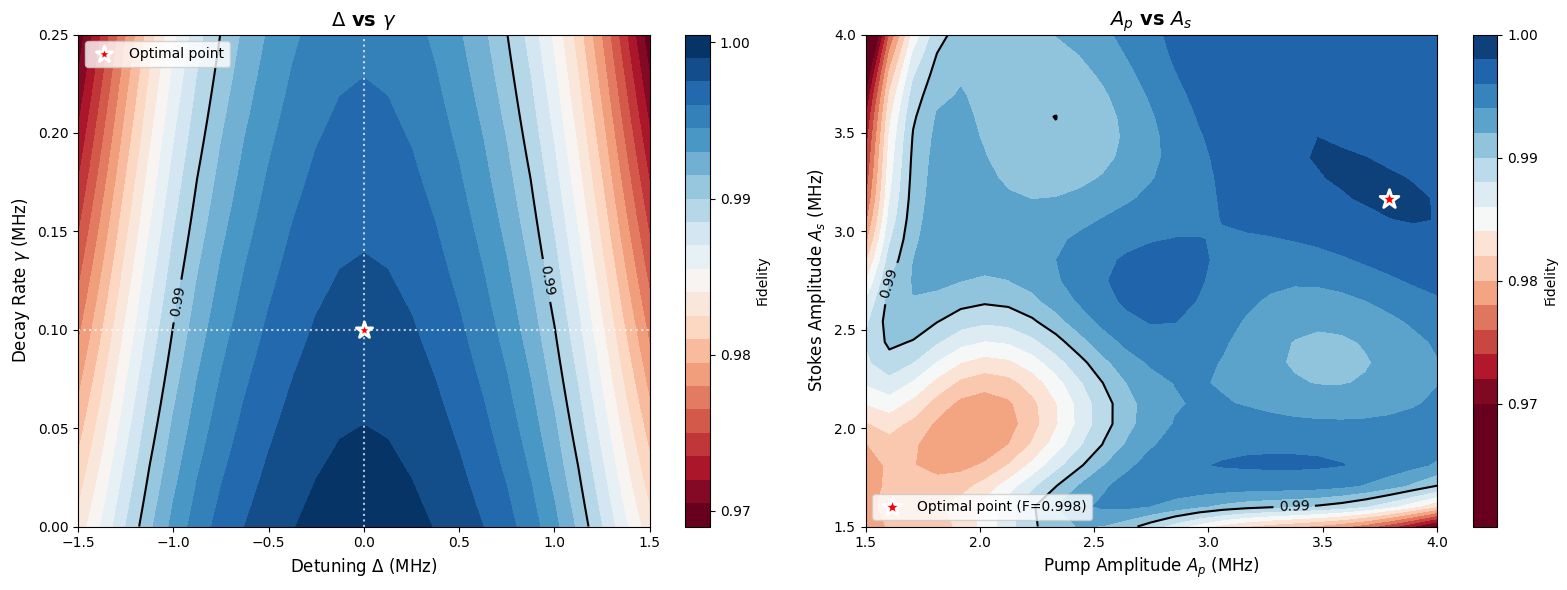


=== Estadísticas Mapa 1 (Δ vs γ) ===
Fidelidad mín: 0.9694, máx: 0.9999

=== Estadísticas Mapa 2 (Ap vs As) ===
Fidelidad mín: 0.9612, máx: 0.9982
Óptimo global: Ap=3.79, As=3.17, F=0.9982


In [10]:
# ==================== VISUALIZACIÓN DE MAPAS 2D ====================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Parámetros para forzar el zoom en la escala de color
VMIN_ZOOM = 0.97
VMAX_ZOOM = 1.0

# ========== Subplot 1: Mapa (Δ, γ) ==========
ax1 = axes[0]
im1 = ax1.contourf(delta_grid, gamma_grid, fidelity_map_1,
                    levels=20, cmap='RdBu', vmin=VMIN_ZOOM, vmax=VMAX_ZOOM)
contours1 = ax1.contour(delta_grid, gamma_grid, fidelity_map_1,
                        levels=[0.90, 0.95, 0.99], colors='black',
                        linewidths=1.5, linestyles=[':', '--', '-'])
ax1.clabel(contours1, inline=True, fontsize=10, fmt='%.2f')

# Marcar punto óptimo (delta=0, gamma de referencia)
ax1.axvline(x=0, color='white', linestyle=':', linewidth=1.5, alpha=0.7)
ax1.axhline(y=gamma, color='white', linestyle=':', linewidth=1.5, alpha=0.7)
ax1.scatter([0], [gamma], c='red', s=150, marker='*',
            edgecolors='white', linewidths=2, zorder=10, label='Optimal point')

ax1.set_xlabel(r'Detuning $\Delta$ (MHz)', fontsize=12)
ax1.set_ylabel(r'Decay Rate $\gamma$ (MHz)', fontsize=12)
ax1.set_title(r'$\Delta$ vs $\gamma$', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
cbar1 = plt.colorbar(im1, ax=ax1, label='Fidelity')
cbar1.set_ticks([0.97, 0.98, 0.99, 1.00])
cbar1.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

# ========== Subplot 2: Mapa (A_pump, A_stokes) ==========
ax2 = axes[1]
im2 = ax2.contourf(A_pump_grid, A_stokes_grid, fidelity_map_2,
                    levels=20, cmap='RdBu', vmin=VMIN_ZOOM, vmax=VMAX_ZOOM)
contours2 = ax2.contour(A_pump_grid, A_stokes_grid, fidelity_map_2,
                        levels=[0.90, 0.95, 0.99], colors='black',
                        linewidths=1.5, linestyles=[':', '--', '-'])
ax2.clabel(contours2, inline=True, fontsize=10, fmt='%.2f')

# Encontrar punto óptimo global (máxima fidelidad)
opt_idx = np.unravel_index(np.argmax(fidelity_map_2), fidelity_map_2.shape)
A_pump_opt = A_pump_grid[opt_idx[1]]
A_stokes_opt = A_stokes_grid[opt_idx[0]]
F_opt = fidelity_map_2[opt_idx]

# Marcar óptimo global (máxima fidelidad en la grilla)
ax2.scatter([A_pump_opt], [A_stokes_opt], c='red', s=200, marker='*',
            edgecolors='white', linewidths=2, zorder=10,
            label=f'Optimal point (F={F_opt:.3f})')

ax2.set_xlabel(r'Pump Amplitude $A_p$ (MHz)', fontsize=12)
ax2.set_ylabel(r'Stokes Amplitude $A_s$ (MHz)', fontsize=12)
ax2.set_title(r'$A_p$ vs $A_s$', fontsize=14, fontweight='bold')
ax2.legend(loc='lower left')

cbar2 = plt.colorbar(im2, ax=ax2, label='Fidelity')
cbar2.set_ticks([0.97, 0.98, 0.99, 1.00])
cbar2.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

plt.tight_layout()
plt.savefig('mapa_fidelidad.pdf', format='pdf')
plt.show()

# ==================== ESTADÍSTICAS ====================
print(f"\n=== Estadísticas Mapa 1 (Δ vs γ) ===")
print(f"Fidelidad mín: {fidelity_map_1.min():.4f}, máx: {fidelity_map_1.max():.4f}")

print(f"\n=== Estadísticas Mapa 2 (Ap vs As) ===")
print(f"Fidelidad mín: {fidelity_map_2.min():.4f}, máx: {fidelity_map_2.max():.4f}")
print(f"Óptimo global: Ap={A_pump_opt:.2f}, As={A_stokes_opt:.2f}, F={F_opt:.4f}")



# 7 INTERPRETATION OF 2D MAPS

### Map 1 ($\Delta$ vs $\gamma$):

* Blue Region: Indicates *high fidelity*.
* Black Contours: Show isolines of constant fidelity (typically $F=0.90, 0.95, 0.99$).
* Red Star: Marks the nominal design point ($\Delta=0, \gamma=0.1$), representing the expected fidelity for these design values.
* Conclusion: The extent of the blue region demonstrates that STIRAP is robust (maintains high fidelity) over a wide range of detuning errors ($\Delta$) and decay rates ($\gamma$), which is crucial for experimental implementation.

### Map 2 ($A_{\text{pump}}$ vs $A_{\text{stokes}}$):

* Optimal Region: Displays a broad central high-fidelity *plateau*.
* Red Star: Identifies the global optimum found within the search grid.
* Conclusion: The map confirms that the optimal solution is not an isolated point, but rather an extended and tolerant region in pulse-amplitude space, facilitating compensation for laser power fluctuations.

## Robust Optimization with Differential Evolution

Instead of optimizing only for nominal parameters, we can optimize the average fidelity over an ensemble of experimental conditions. This results in more robust pulses.

### Methodology

1. Define ensemble: Parameter distribution (e.g., detuning ~ N(0, σ)).
2. Objective function: Minimize `1 - <F>` where `<F>` is the average fidelity.
3. Algorithm: Differential Evolution (global search).
4. Result: Parameters optimized for maximum robustness.

### Differential Evolution

Unlike Nelder–Mead (local optimization), *differential evolution* is an evolutionary algorithm that:

- Explores the entire search space.
- Is robust against local minima.
- Does not require gradients (making it computationally less demanding in gradient-free problems).
- Is well suited for noisy objective functions (such as ensemble-averaged fidelities).

In [11]:
# ==================== OPTIMIZACIÓN ROBUSTA CON DIFFERENTIAL EVOLUTION ====================

from scipy.optimize import differential_evolution
import numpy as np
import qutip as qt

print("="*70)
print("OPTIMIZACIÓN ROBUSTA CON DIFFERENTIAL EVOLUTION")
print("="*70)
print()

# Usar operadores ya definidos
ops = build_ops()

# Parámetros base
t_total = 23.0
tlist_robust = np.linspace(0, t_total, 501)
psi0 = ops["e1"]
gamma_nominal = 0.1

# Operadores del Hamiltoniano
H_pump_op = ops["s31"] + ops["s13"]
H_stokes_op = ops["s32"] + ops["s23"]
e_ops = [ops["s11"], ops["s22"], ops["s33"]]

def pump_pulse_robust(t, args):
    return args['A_pump'] * np.exp(-(t - args['t_pump'])**2 / (2*args['sigma']**2))

def stokes_pulse_robust(t, args):
    return args['A_stokes'] * np.exp(-(t - args['t_stokes'])**2 / (2*args['sigma']**2))

# Ensemble de detunings (distribución para robustez)
n_samples_ensemble = 10  # Número de muestras del ensemble
detuning_std = 0.5  # Desviación estándar del detuning (MHz)
np.random.seed(42)
detuning_samples = np.random.normal(0, detuning_std, n_samples_ensemble)

def objective_robust(params):
    """
    Función objetivo para optimización robusta.
    Minimiza 1 - <F> donde <F> es fidelidad promedio sobre ensemble de detunings.
    """
    A_pump, A_stokes, sigma = params

    # Restricciones
    if A_pump < 0.5 or A_stokes < 0.5 or sigma < 0.5:
        return 1.0

    # Tiempos fijos (STIRAP estándar)
    t_pump = 14.0
    t_stokes = 9.0

    args = {
        'A_pump': A_pump,
        'A_stokes': A_stokes,
        't_pump': t_pump,
        't_stokes': t_stokes,
        'sigma': sigma
    }

    fidelities = []
    c_ops = [np.sqrt(gamma_nominal) * ops["s13"]]

    for delta in detuning_samples:
        H = [
            delta * ops["s22"],
            [H_pump_op, pump_pulse_robust],
            [H_stokes_op, stokes_pulse_robust]
        ]

        try:
            result = qt.mesolve(H, psi0, tlist_robust, c_ops, e_ops, args=args)
            fidelities.append(result.expect[1][-1])  # P2 final
        except:
            fidelities.append(0.0)

    # Minimizar 1 - fidelidad promedio
    return 1.0 - np.mean(fidelities)

# Límites para los parámetros [A_pump, A_stokes, sigma]
bounds = [(1.0, 5.0), (1.0, 5.0), (1.0, 4.0)]

print("Configuración:")
print(f"  Muestras del ensemble: {n_samples_ensemble}")
print(f"  Desviación de detuning: ±{detuning_std:.2f} MHz")
print(f"  γ nominal: {gamma_nominal}")
print()
print("Límites de búsqueda:")
print(f"  A_pump  ∈ [{bounds[0][0]:.1f}, {bounds[0][1]:.1f}] MHz")
print(f"  A_stokes ∈ [{bounds[1][0]:.1f}, {bounds[1][1]:.1f}] MHz")
print(f"  sigma   ∈ [{bounds[2][0]:.1f}, {bounds[2][1]:.1f}]")
print()
print("Iniciando optimización...")
print("(Esto puede tardar ~60-120 segundos)")
print()

# Optimizar con Differential Evolution
result_robust = differential_evolution(
    objective_robust,
    bounds,
    seed=42,
    maxiter=50,    # Reducido para demo (usar 200+ en producción)
    popsize=10,    # Tamaño de población
    tol=0.01,
    atol=0.001,
    disp=True      # Mostrar progreso
)

A_pump_robust, A_stokes_robust, sigma_robust = result_robust.x

print()
print("Optimización completada.")
print()
print("-"*70)
print("PARÁMETROS ROBUSTOS OPTIMIZADOS")
print("-"*70)
print(f"  A_pump   = {A_pump_robust:.4f} MHz")
print(f"  A_stokes = {A_stokes_robust:.4f} MHz")
print(f"  sigma    = {sigma_robust:.4f}")
print()
print(f"  Fidelidad promedio: {1.0 - result_robust.fun:.6f}")
print("-"*70)

# Guardar parámetros robustos
args_robust = {
    't_pump': 14.0,
    't_stokes': 9.0,
    'A_pump': A_pump_robust,
    'A_stokes': A_stokes_robust,
    'sigma': sigma_robust
}

print()
print("="*70)

OPTIMIZACIÓN ROBUSTA CON DIFFERENTIAL EVOLUTION

Configuración:
  Muestras del ensemble: 10
  Desviación de detuning: ±0.50 MHz
  γ nominal: 0.1

Límites de búsqueda:
  A_pump  ∈ [1.0, 5.0] MHz
  A_stokes ∈ [1.0, 5.0] MHz
  sigma   ∈ [1.0, 4.0]

Iniciando optimización...
(Esto puede tardar ~60-120 segundos)



/usr/local/python/3.12.1/lib/python3.12/site-packages/qutip/solver/solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


differential_evolution step 1: f(x)= 0.001429634106646538
differential_evolution step 2: f(x)= 0.001429634106646538
differential_evolution step 3: f(x)= 0.001234243170197713
differential_evolution step 4: f(x)= 0.001234243170197713
differential_evolution step 5: f(x)= 0.001234243170197713
Polishing solution with 'L-BFGS-B'

Optimización completada.

----------------------------------------------------------------------
PARÁMETROS ROBUSTOS OPTIMIZADOS
----------------------------------------------------------------------
  A_pump   = 5.0000 MHz
  A_stokes = 5.0000 MHz
  sigma    = 2.9229

  Fidelidad promedio: 0.998938
----------------------------------------------------------------------



COMPARISON: STANDARD VS ROBUST PARAMETERS

Evaluating standard vs robust parameters...
Evaluation completed.

----------------------------------------------------------------------
COMPARISON STATISTICS
----------------------------------------------------------------------
Metric                         Standard        Robust         
----------------------------------------------------------------------
Average fidelity               0.991280       0.997142
Minimum fidelity               0.977569       0.992591
Maximum fidelity               0.998166       0.999383
Standard deviation             0.006544       0.002098
----------------------------------------------------------------------

✓ Improvement in average fidelity: +0.005861
✓ Improvement in minimum fidelity: +0.015022

Evaluando ensemble de detunings para distribución...
Evaluación completada.


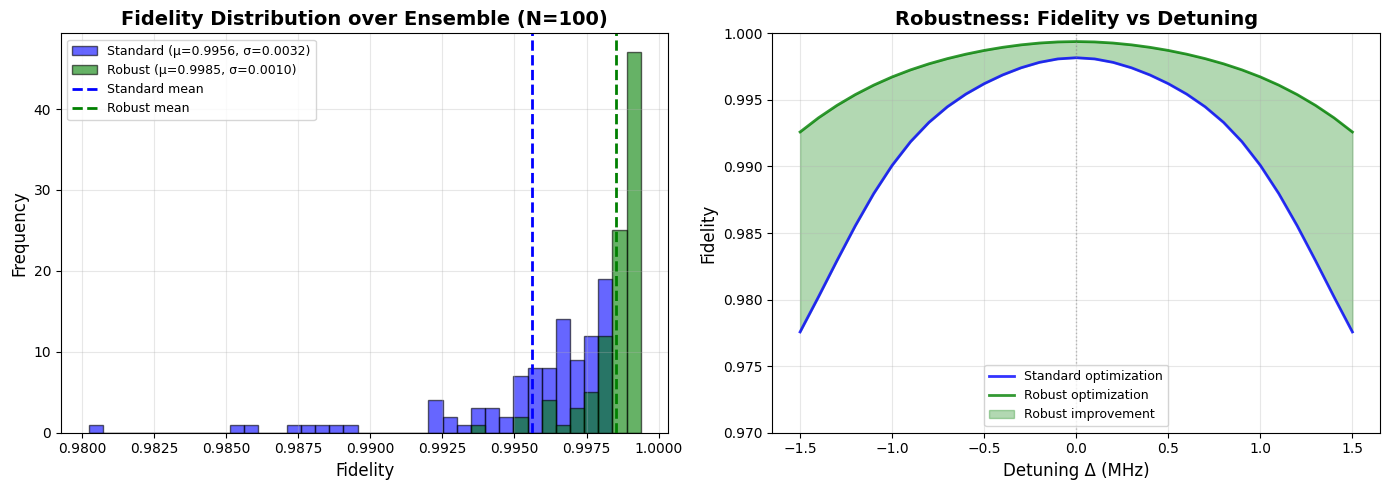


Conclusión:
  La optimización robusta (Differential Evolution) busca maximizar
  la fidelidad PROMEDIO sobre un ensemble de detunings, lo que
  produce parámetros más tolerantes a variaciones experimentales.


In [12]:
# ==================== COMPARISON: STANDARD VS ROBUST PARAMETERS ====================

import matplotlib.pyplot as plt
import numpy as np

print("="*70)
print("COMPARISON: STANDARD VS ROBUST PARAMETERS")
print("="*70)
print()

# Detuning range for evaluation
delta_test_range = np.linspace(-1.5, 1.5, 31)

# Evaluate both parameter sets
fidelities_standard = []
fidelities_robust_eval = []

c_ops_test = [np.sqrt(gamma_nominal) * ops["s13"]]

print("Evaluating standard vs robust parameters...")

for delta in delta_test_range:
    H_temp = [
        delta * ops["s22"],
        [H_pump_op, pump_pulse_robust],
        [H_stokes_op, stokes_pulse_robust]
    ]

    # Evaluate with standard parameters (from local optimization)
    result_std = qt.mesolve(H_temp, psi0, tlist_robust,
                            c_ops_test, e_ops, args=args_optimized)
    fidelities_standard.append(result_std.expect[1][-1])

    # Evaluate with robust parameters
    result_rob = qt.mesolve(H_temp, psi0, tlist_robust,
                            c_ops_test, e_ops, args=args_robust)
    fidelities_robust_eval.append(result_rob.expect[1][-1])

fidelities_standard = np.array(fidelities_standard)
fidelities_robust_eval = np.array(fidelities_robust_eval)

print("Evaluation completed.")
print()

# Statistics
print("-"*70)
print("COMPARISON STATISTICS")
print("-"*70)
print(f"{'Metric':<30} {'Standard':<15} {'Robust':<15}")
print("-"*70)
print(f"{'Average fidelity':<30} {np.mean(fidelities_standard):.6f}       {np.mean(fidelities_robust_eval):.6f}")
print(f"{'Minimum fidelity':<30} {np.min(fidelities_standard):.6f}       {np.min(fidelities_robust_eval):.6f}")
print(f"{'Maximum fidelity':<30} {np.max(fidelities_standard):.6f}       {np.max(fidelities_robust_eval):.6f}")
print(f"{'Standard deviation':<30} {np.std(fidelities_standard):.6f}       {np.std(fidelities_robust_eval):.6f}")
print("-"*70)

# Improvement
mejora_promedio = np.mean(fidelities_robust_eval) - np.mean(fidelities_standard)
mejora_minima = np.min(fidelities_robust_eval) - np.min(fidelities_standard)

print()
if mejora_promedio > 0:
    print(f"✓ Improvement in average fidelity: +{mejora_promedio:.6f}")
else:
    print(f"  No significant improvement in average: {mejora_promedio:.6f}")

if mejora_minima > 0:
    print(f"✓ Improvement in minimum fidelity: +{mejora_minima:.6f}")
else:
    print(f"  Sin mejora significativa en mínimo: {mejora_minima:.6f}")

print()
print("="*70)

# ==================== VISUALIZACIÓN ====================

# Generate a random ensemble for the fidelity distribution
n_ensemble = 100
np.random.seed(123)
detunings_ensemble = np.random.normal(0, 0.5, n_ensemble)  # σ = 0.5 MHz

fidelities_std_ensemble = []
fidelities_rob_ensemble = []

print("Evaluando ensemble de detunings para distribución...")

for delta in detunings_ensemble:
    H_temp = [
        delta * ops["s22"],
        [H_pump_op, pump_pulse_robust],
        [H_stokes_op, stokes_pulse_robust]
    ]

    result_std = qt.mesolve(H_temp, psi0, tlist_robust,
                            c_ops_test, e_ops, args=args_optimized)
    fidelities_std_ensemble.append(result_std.expect[1][-1])

    result_rob = qt.mesolve(H_temp, psi0, tlist_robust,
                            c_ops_test, e_ops, args=args_robust)
    fidelities_rob_ensemble.append(result_rob.expect[1][-1])

fidelities_std_ensemble = np.array(fidelities_std_ensemble)
fidelities_rob_ensemble = np.array(fidelities_rob_ensemble)

# Estadísticas del ensemble
std_mean = np.mean(fidelities_std_ensemble)
std_std = np.std(fidelities_std_ensemble)
rob_mean = np.mean(fidelities_rob_ensemble)
rob_std = np.std(fidelities_rob_ensemble)

print("Evaluación completada.")

# ==================== FIGURA CON DOS SUBPLOTS ====================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ========== Subplot 1: Histogramas de Fidelidad ==========
ax1 = axes[0]
# Usar los mismos bins para ambos histogramas
all_fidelities = np.concatenate([fidelities_std_ensemble, fidelities_rob_ensemble])
bins_shared = np.linspace(all_fidelities.min(), all_fidelities.max(), 40)

ax1.hist(fidelities_std_ensemble, bins=bins_shared, alpha=0.6, color='blue',
         label=f'Standard (μ={std_mean:.4f}, σ={std_std:.4f})', edgecolor='black')
ax1.hist(fidelities_rob_ensemble, bins=bins_shared, alpha=0.6, color='green',
         label=f'Robust (μ={rob_mean:.4f}, σ={rob_std:.4f})', edgecolor='black')
ax1.axvline(x=std_mean, color='blue', linestyle='--', linewidth=2, label='Standard mean')
ax1.axvline(x=rob_mean, color='green', linestyle='--', linewidth=2, label='Robust mean')
ax1.set_xlabel('Fidelity', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title(f'Fidelity Distribution over Ensemble (N={n_ensemble})', fontsize=14, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# ========== Subplot 2: Fidelidad vs Detuning ==========
ax2 = axes[1]

ax2.plot(delta_test_range, fidelities_standard, 'b-', linewidth=2,
         label='Standard optimization', alpha=0.8)
ax2.plot(delta_test_range, fidelities_robust_eval, 'g-', linewidth=2,
         label='Robust optimization', alpha=0.8)

ax2.fill_between(delta_test_range, fidelities_standard, fidelities_robust_eval,
                 where=(fidelities_robust_eval >= fidelities_standard),
                 alpha=0.3, color='green', label='Robust improvement')
ax2.axvline(x=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)

ax2.set_xlabel('Detuning Δ (MHz)', fontsize=12)
ax2.set_ylabel('Fidelity', fontsize=12)
ax2.set_title('Robustness: Fidelity vs Detuning', fontsize=14, fontweight='bold')
ax2.legend(loc='lower center', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.97, 1.00])

plt.tight_layout()
plt.savefig('comparacion_robustez.pdf', format='pdf')
plt.show()

print()
print("Conclusión:")
print("  La optimización robusta (Differential Evolution) busca maximizar")
print("  la fidelidad PROMEDIO sobre un ensemble de detunings, lo que")
print("  produce parámetros más tolerantes a variaciones experimentales.")


# 8 ROBUST OPTIMIZATION CONCLUSIONS

Robust optimization, such as that achieved using differential evolution–based algorithms, produces pulses that are designed to maintain high fidelity even under experimental uncertainties.

### Observed Advantages:

1.  Reduced Fidelity Variance: The fidelity distribution becomes narrower, implying more predictable performance.
2.  Improved Minimum Fidelity: The worst-case fidelity result is significantly higher than that of the nominally optimized pulse.
3.  Broader Robust Operating Range: The pulse tolerates a wider range of control-parameter errors (e.g., detuning or amplitude).
4.  Trade-off: Robustness may require a slight sacrifice in nominal fidelity (obtained under ideal conditions) in order to gain overall stability.
